# Claude Sonnet 4
---


In [1]:
# Imports
import os
import sys
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

sys.path.append(r"C:\Users\janbe\Documents\GitHub Repos\pulse")
from src.eval.llm_analyzer import LLMAnalyzer
from src.eval.pulse_score import PULSEScoreCalculator

## Analysis of different prompting approaches
---

In [8]:
model_id = "claudesonnet4"
base_output_dir = (
    r"C:\Users\janbe\Documents\GitHub Repos\pulse\output_to_keep\results_benchmark"
)
model_output_dir = os.path.join(base_output_dir, "llms", model_id)
results_output_dir = os.path.join(base_output_dir, r"results_output")


prompt_approaches = os.listdir(model_output_dir)
print(prompt_approaches)

# Try to load results_dict from json before calculating
results_loaded = False
results_output_jsons = os.path.join(results_output_dir, "jsons")
results_json_path = f"{model_id}_results.json"

if not results_loaded:
    best_prompt_approach = None

    results_dict = {}
    mdata_dict = {}
    cost_df = pd.DataFrame()

    for prompt_approach in prompt_approaches:

        if not os.path.isdir(os.path.join(model_output_dir, prompt_approach)):
            continue

        print("=" * 50)
        print(f"\nPrompting Approach {prompt_approach}")

        cat_files = LLMAnalyzer.categorize_files(
            [os.path.join(model_output_dir, prompt_approach)],
            verbose=False,
        )

        df_mdata = LLMAnalyzer.load_metadata(cat_files["metadata_files"], verbose=True)
        summary = LLMAnalyzer.print_approach_summary(
            df_mdata, input_token_cost=3, output_token_cost=15
        )

        # Filter for final prediction step if agent is used

        if "Step Name" in df_mdata.columns:

            df_mdata = df_mdata[
                df_mdata["Step Name"] == "final_prediction"
            ].reset_index(drop=True)

        ps = PULSEScoreCalculator()

        pulse_score = ps.calculate_pulse_score_from_raw_data(
            df=df_mdata,
        )
        pulse_score["model_id"] = model_id
        pulse_score["prompting_id"] = prompt_approach

        pulse_score_temp = pulse_score["overall"]["overall_score"]

        results_dict[prompt_approach] = pulse_score
        mdata_dict[prompt_approach] = df_mdata
        cost_df[prompt_approach] = [
            summary["input_cost"].sum(),
            summary["output_cost"].sum(),
            summary["thinking_cost"].sum(),
            summary["total_cost"].sum(), # Reasoning Tokens included in output cost
        ]
        cost_df.index = ["input_cost", "output_cost", "thinking_cost", "total_cost"]

        if best_prompt_approach is None or pulse_score_temp > best_prompt_approach[1]:

            best_prompt_approach = (prompt_approach, pulse_score_temp)

    display(cost_df)

    print(
        f"\nBest prompt approach: {best_prompt_approach[0]} with PULSE score: {best_prompt_approach[1]}"
    )

    # Save results as json. Uses pulse-result format
    json_output_path = os.path.join(results_output_jsons, f"{model_id}_results.json")
    LLMAnalyzer.save_results_dict_as_json(
        results_dict, json_output_path
    )

['hybrid_reasoning_agent_preprocessor', 'sarvari_2024_aggregation_preprocessor', 'zhu_2024b_zero_shot_preprocessor']

Prompting Approach hybrid_reasoning_agent_preprocessor
Extracting metadata from files:
Model Name: ClaudeSonnet4, Task: aki, Dataset: eicu, Timestamp: 20250711_173050
Model Name: ClaudeSonnet4, Task: aki, Dataset: hirid, Timestamp: 20250711_173050
Model Name: ClaudeSonnet4, Task: aki, Dataset: miiv, Timestamp: 20250711_173050
Model Name: ClaudeSonnet4, Task: mortality, Dataset: eicu, Timestamp: 20250711_173050
Model Name: ClaudeSonnet4, Task: mortality, Dataset: hirid, Timestamp: 20250711_173050
Model Name: ClaudeSonnet4, Task: mortality, Dataset: miiv, Timestamp: 20250711_173050
Model Name: ClaudeSonnet4, Task: sepsis, Dataset: eicu, Timestamp: 20250711_173050
Model Name: ClaudeSonnet4, Task: sepsis, Dataset: hirid, Timestamp: 20250711_173050
Model Name: ClaudeSonnet4, Task: sepsis, Dataset: miiv, Timestamp: 20250711_173050


--- Approach Summary ---
- Number of Sample

,hybrid_reasoning_agent_preprocessor,sarvari_2024_aggregation_preprocessor,zhu_2024b_zero_shot_preprocessor
input_cost,52.538301,1.766118,73.292271
output_cost,195.622695,3.266055,95.204625
thinking_cost,0.000000,0.000000,0.000000
total_cost,248.160996,5.032173,168.496896



Best prompt approach: hybrid_reasoning_agent_preprocessor with PULSE score: 57.31233135653227
Saved 21 result entries to C:\Users\janbe\Documents\GitHub Repos\pulse\output_to_keep\results_benchmark\results_output\jsons\claudesonnet4_results.json


In [9]:
mdata_dict["sarvari_2024_aggregation_preprocessor"]

,Input Prompt,Target Label,Predicted Probability,Predicted Diagnosis,Predicted Explanation,Tokenization Time,Inference Time,Input Tokens,Output Tokens,Thinking Tokens,Thinking Output,model_name,task,dataset,timestamp
0,Suggest a diagnosis of mortality for the follo...,0,0.72,mortality,Septic shock presentation: severe inflammation...,0,0,1962,844,0,Let me analyze this patient's data systematica...,ClaudeSonnet4,mortality,eicu,20250722_130446
1,Suggest a diagnosis of mortality for the follo...,0,0.25,not-mortality,Mixed clinical picture: severe inflammation (C...,0,0,1963,1088,0,Let me analyze this patient data systematicall...,ClaudeSonnet4,mortality,eicu,20250722_130446
2,Suggest a diagnosis of mortality for the follo...,0,0.78,mortality,Sepsis with multi-organ dysfunction: CRP 76.25...,0,0,1962,678,0,Let me analyze this patient data systematicall...,ClaudeSonnet4,mortality,eicu,20250722_130446
3,Suggest a diagnosis of mortality for the follo...,0,0.85,mortality,Critical sepsis with multi-organ dysfunction: ...,0,0,1962,841,0,Let me analyze this patient data systematicall...,ClaudeSonnet4,mortality,eicu,20250722_130446
4,Suggest a diagnosis of mortality for the follo...,0,0.30,not-mortality,Moderate risk profile: elevated inflammatory m...,0,0,1962,696,0,Let me analyze this patient data carefully to ...,ClaudeSonnet4,mortality,eicu,20250722_130446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,Suggest a diagnosis of mortality for the follo...,0,0.78,mortality,High-risk 91-year-old with severe immunosuppre...,0,0,1962,707,0,Let me analyze the patient data systematically...,ClaudeSonnet4,mortality,miiv,20250722_130446
296,Suggest a diagnosis of mortality for the follo...,0,0.25,not-mortality,Young patient (27 years) with signs of infecti...,0,0,1962,788,0,Let me analyze this patient data for signs of ...,ClaudeSonnet4,mortality,miiv,20250722_130446
297,Suggest a diagnosis of mortality for the follo...,0,0.75,mortality,Severe acute kidney injury with creatinine up ...,0,0,1962,601,0,"Looking at this patient data, I need to assess...",ClaudeSonnet4,mortality,miiv,20250722_130446
298,Suggest a diagnosis of mortality for the follo...,0,0.35,not-mortality,Moderate risk patient with severe inflammation...,0,0,1962,823,0,Let me analyze this patient data to look for s...,ClaudeSonnet4,mortality,miiv,20250722_130446


Summary Metrics of all Prompting Appraches

C:\Users\janbe\Documents\GitHub Repos\pulse\src\eval\llm_analyzer.py:865: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_df = plot_df.groupby(["Group", "Metric"], as_index=False).agg(


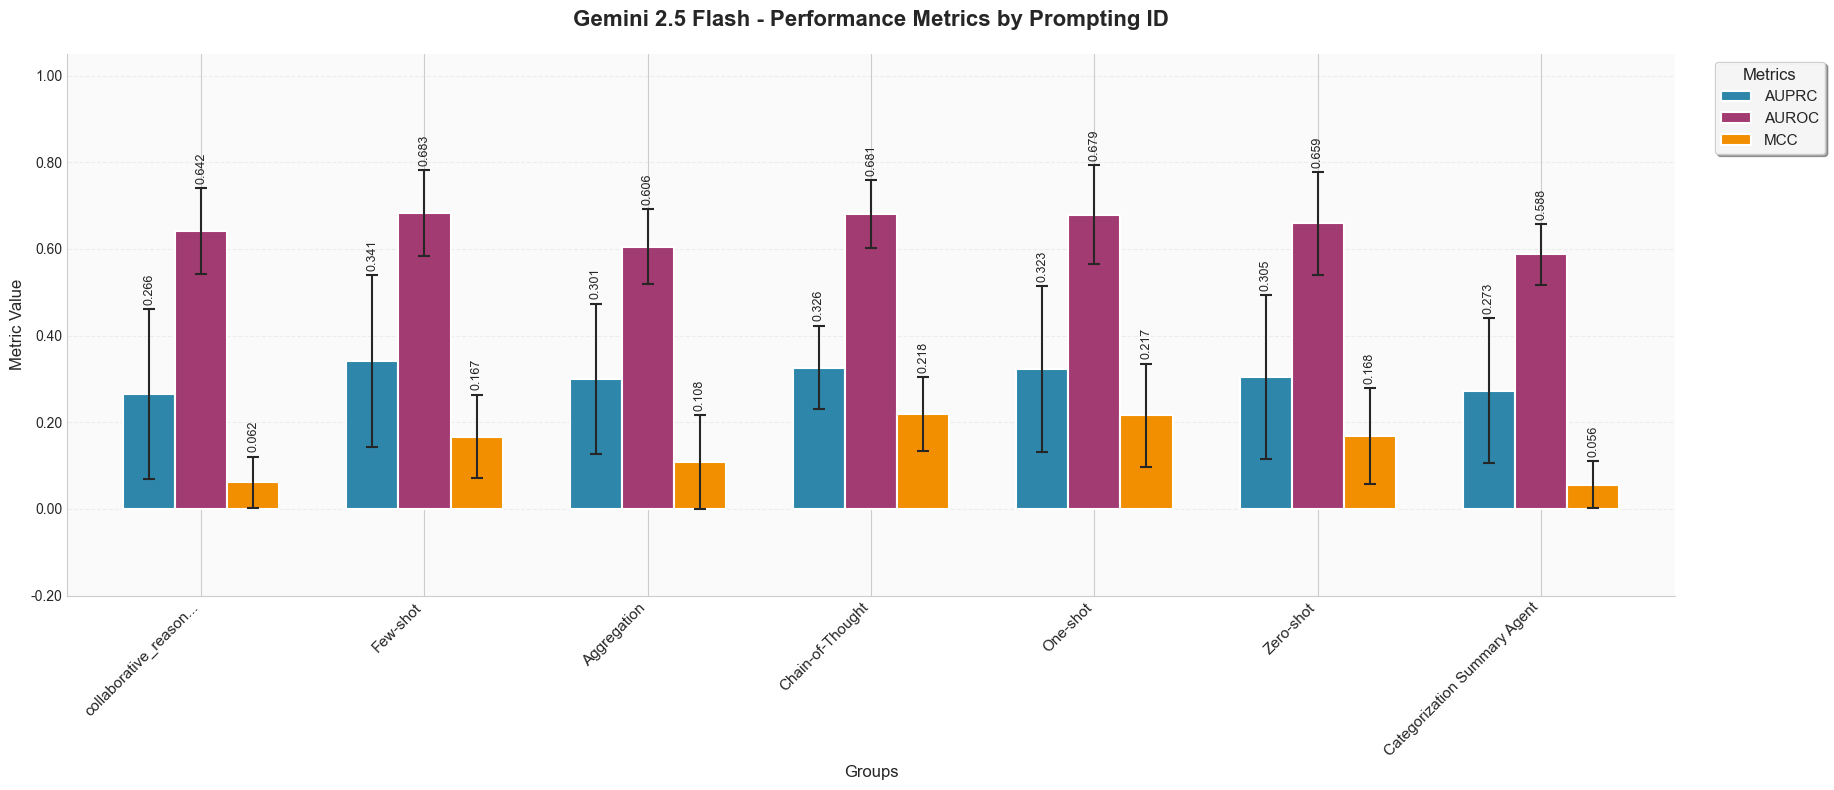

In [5]:
df_results = LLMAnalyzer.load_metrics_from_prompt_approaches(
    base_output_dir, prompt_approaches
)



LLMAnalyzer.plot_metrics(
    df_results, group=["prompting_id"], title_prefix="Gemini 2.5 Flash - "
)

Metrics per Prompt and Task

C:\Users\janbe\Documents\GitHub Repos\pulse\src\eval\llm_analyzer.py:865: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_df = plot_df.groupby(["Group", "Metric"], as_index=False).agg(


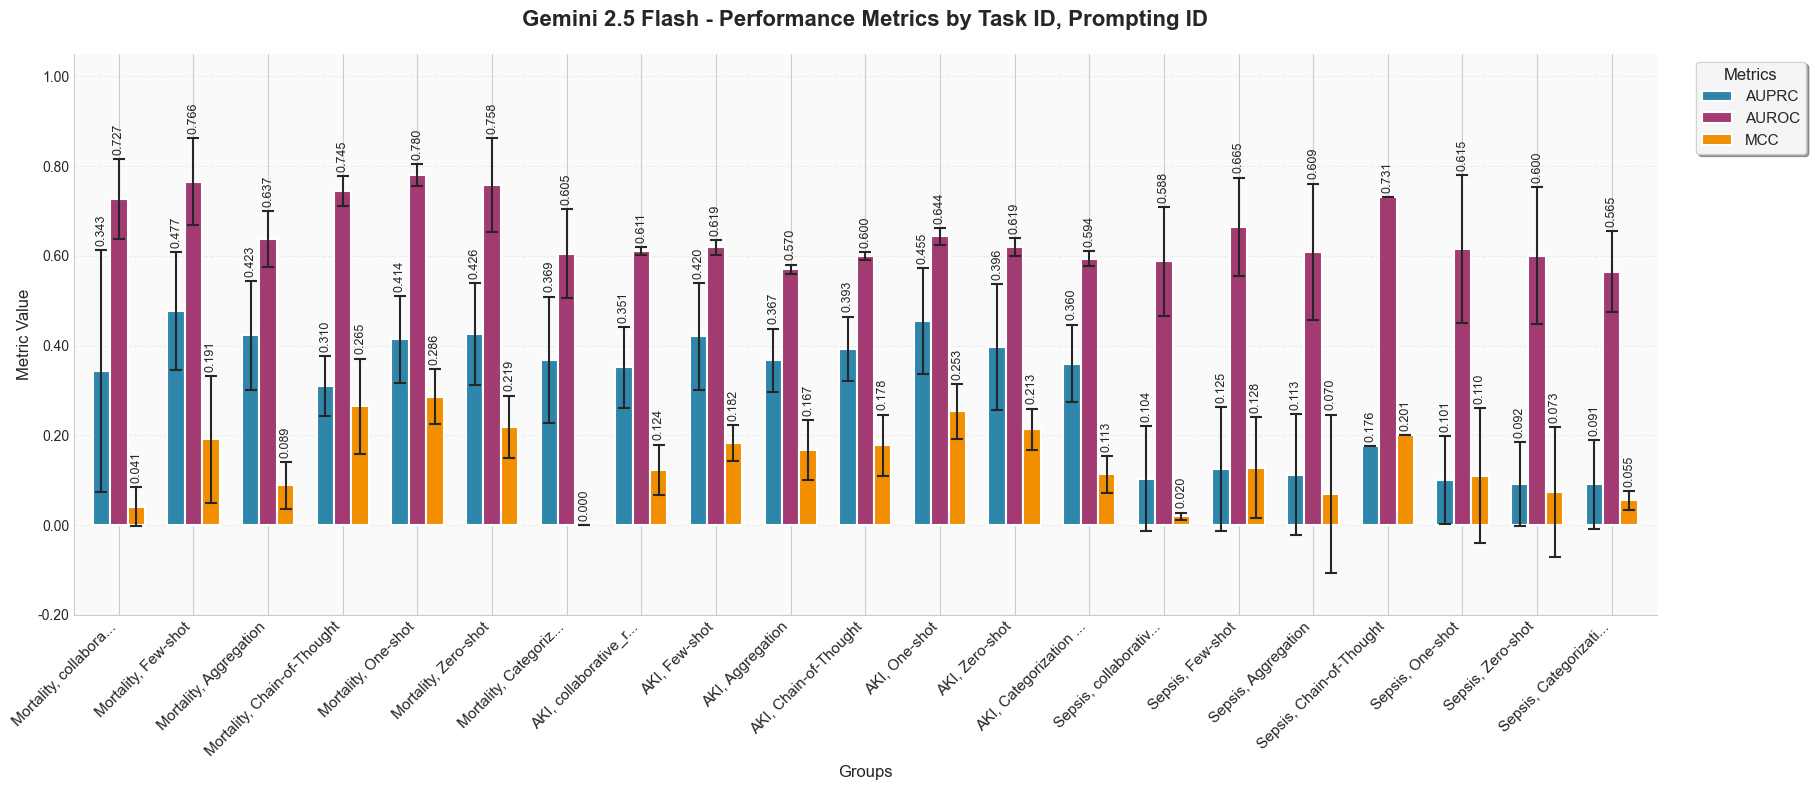

In [6]:
LLMAnalyzer.plot_metrics(
    df_results,
    group=["task_id", "prompting_id"],
    title_prefix="Gemini 2.5 Flash - ",
)

Analysis of best prompting approach

In [8]:
prompt_dropdown = widgets.Dropdown(
    options=prompt_approaches,
    value=best_prompt_approach[0],
    description='Prompt Approach:',
    style={'description_width': 'initial'}
)
display(prompt_dropdown)


Dropdown(description='Prompt Approach:', index=1, options=('collaborative_reasoning_agent_preprocessor', 'liu_…

In [9]:
best_approach_path = os.path.join(
    base_output_dir, prompt_dropdown.value
)
print(f"Loading metadata from: {best_approach_path}")
print("======================================================")
cat_files = LLMAnalyzer.categorize_files([best_approach_path], verbose=False)
df_mdata = LLMAnalyzer.load_metadata(cat_files["metadata_files"])

Loading metadata from: C:\Users\janbe\Documents\GitHub Repos\pulse\output_to_keep\results_benchmark\llms\gemini2p5flash\liu_2023_few_shot_preprocessor
Model Name: Gemini2p5flash, Task: aki, Dataset: eicu, Timestamp: 20250623_140022
Model Name: Gemini2p5flash, Task: aki, Dataset: hirid, Timestamp: 20250623_140022
Model Name: Gemini2p5flash, Task: aki, Dataset: miiv, Timestamp: 20250623_140022
Model Name: Gemini2p5flash, Task: mortality, Dataset: eicu, Timestamp: 20250623_140022
Model Name: Gemini2p5flash, Task: mortality, Dataset: hirid, Timestamp: 20250623_140022
Model Name: Gemini2p5flash, Task: mortality, Dataset: miiv, Timestamp: 20250623_140022
Model Name: Gemini2p5flash, Task: sepsis, Dataset: eicu, Timestamp: 20250623_140022
Model Name: Gemini2p5flash, Task: sepsis, Dataset: hirid, Timestamp: 20250623_140022
Model Name: Gemini2p5flash, Task: sepsis, Dataset: miiv, Timestamp: 20250623_140022


In [10]:
LLMAnalyzer.print_approach_summary(df_mdata)

,task,dataset,mean_inference_time,total_inference_time,mean_input_tokens,total_input_tokens,mean_output_tokens,total_output_tokens,positive_samples,negative_samples,total_samples,pos_neg_ratio
0,aki,eicu,2.75s,2703.15s,9010,8866155,128,126038,305,679,984,0.45
1,aki,hirid,1.84s,1806.64s,9964,9784235,112,109797,159,823,982,0.19
2,aki,miiv,1.86s,1833.72s,9100,8954791,120,117705,229,755,984,0.30
3,mortality,eicu,2.23s,222.84s,30493,3049349,125,12511,7,93,100,0.08
4,mortality,hirid,2.74s,273.80s,34755,3475511,145,14503,11,89,100,0.12
5,mortality,miiv,4.03s,403.40s,30507,3050680,114,11390,12,88,100,0.14
6,sepsis,eicu,3.54s,3466.62s,9121,8938234,151,148284,47,933,980,0.05
7,sepsis,hirid,2.60s,2516.43s,10108,9794475,151,146664,73,896,969,0.08
8,sepsis,miiv,1.89s,1867.99s,9063,8972646,138,136322,25,965,990,0.03


--- Prediction Distribution Statistics ---
Total Records: 300
Ground Truth Positive Samples: 30
Ground Truth Negative Samples: 270
Mean Predicted Probability (Average of All Predictions): 0.456
Std Predicted Probability: 0.330
Calibration Error (|Mean Pred. Prob. - Ground Truth Pos. Rate|): 0.356
True Positives: 23
True Negatives: 143
False Positives: 127
False Negatives: 7
Accuracy (at 0.5 threshold): 0.553
AUPRC: 0.482


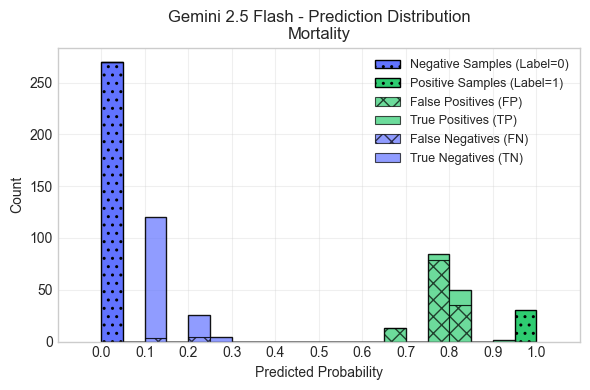

--- Prediction Distribution Statistics ---
Total Records: 2939
Ground Truth Positive Samples: 145
Ground Truth Negative Samples: 2794
Mean Predicted Probability (Average of All Predictions): 0.415
Std Predicted Probability: 0.338
Calibration Error (|Mean Pred. Prob. - Ground Truth Pos. Rate|): 0.366
True Positives: 103
True Negatives: 1761
False Positives: 1032
False Negatives: 42
Accuracy (at 0.5 threshold): 0.635
Could not calculate AUPRC: Input contains NaN.. Make sure sklearn.metrics.average_precision_score is available.


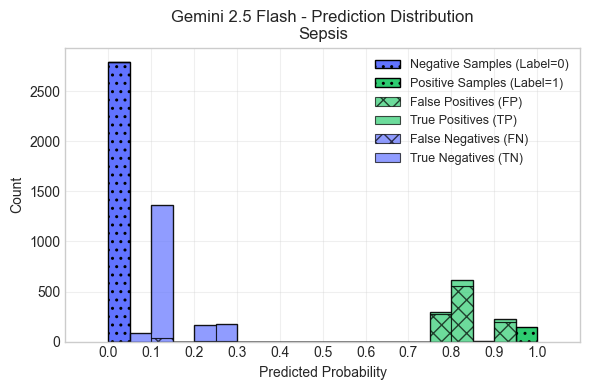

--- Prediction Distribution Statistics ---
Total Records: 2950
Ground Truth Positive Samples: 693
Ground Truth Negative Samples: 2257
Mean Predicted Probability (Average of All Predictions): 0.261
Std Predicted Probability: 0.331
Calibration Error (|Mean Pred. Prob. - Ground Truth Pos. Rate|): 0.026
True Positives: 260
True Negatives: 1897
False Positives: 360
False Negatives: 433
Accuracy (at 0.5 threshold): 0.731
AUPRC: 0.448


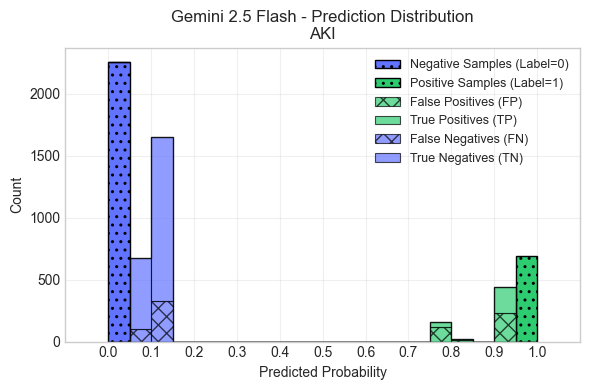

In [12]:
# Distribution of predictions
LLMAnalyzer.plot_prediction_distribution(
    df_mdata,
    title_prefix="Gemini 2.5 Flash - Prediction Distribution",
    data_filter={"task": ["mortality"]},
    show_stats=True,
    color_neg="#6173FF", 
    color_pos="#2ECC71"  
)
LLMAnalyzer.plot_prediction_distribution(
    df_mdata,
    title_prefix="Gemini 2.5 Flash - Prediction Distribution",
    data_filter={"task": ["sepsis"]},
    show_stats=True,
    color_neg="#6173FF",
    color_pos="#2ECC71",
)
LLMAnalyzer.plot_prediction_distribution(
    df_mdata,
    title_prefix="Gemini 2.5 Flash - Prediction Distribution",
    data_filter={"task": ["aki"]},
    show_stats=True,
    color_neg="#6173FF",
    color_pos="#2ECC71",
)

---